## 0. Import statements

In [1]:
import sbmlnetwork
import libsbml

import pandas as pd
import tellurium as te
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import numpy as np

In [2]:
rxns = pd.read_csv('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M0.csv')

## 1. Retrieve coordinates from KEGG
### 1a. Get the (x,y) coordinates for each species in the KEGG map

In [3]:
def get_kegg_orthology_ids(reaction_ids):
    orthology_dict = {}
    for reaction_id in reaction_ids:
        url = f"https://www.kegg.jp/dbget-bin/www_bget?rn:{reaction_id}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the orthology section
        orthology_section = soup.find('th', string="Orthology")
        if orthology_section:
            # Get the orthology ID from the adjacent <td> tag
            orthology_ids = orthology_section.find_next('td').find_all('a')
            # Filter IDs that start with 'K'
            orthology_dict[reaction_id] = [ortho_id.get_text() for ortho_id in orthology_ids if ortho_id.get_text().startswith('K')]
        else:
            orthology_dict[reaction_id] = []
    
    return orthology_dict

In [4]:
orthology_ids = get_kegg_orthology_ids(rxns['Reaction ID'])

In [5]:
import xml.etree.ElementTree as ET
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas

def map_reaction_to_entry_id(xml_file_path, reaction_orthology_dict):
    # Parse the XML file
    pathway = KGML_parser.read(open(xml_file_path, 'r'))

    # Initialize dictionary to hold the reaction ID -> entry ID mapping
    reaction_entry_map = {}

    # Loop through each entry in the pathway
    for entry in pathway.entries.values():
        # Check if the entry is of type 'ortholog'
        if entry.type == "ortholog":
            # Extract the orthology IDs (split by space, remove 'ko:' prefix)
            orthology_ids_in_entry = entry.name.replace('ko:', '').split()

            # Convert to set for comparison
            orthology_ids_in_entry_set = set(orthology_ids_in_entry)

            # Loop through the reaction dictionary
            for reaction_id, orthology_ids in reaction_orthology_dict.items():
                if len(orthology_ids)==0:
                    continue
                # Convert orthology_ids from the reaction dictionary to a set
                orthology_ids_set = set(orthology_ids)

                # Check if all orthology IDs in the entry are present in orthology_ids_set
                # CHANGING THIS AS AN EXPERIMENT: CHECK IF ANY OF THE ORTHOLOGY IDS IN THE ENTRY ARE PRESENT IN ORTHOLOGY_IDS_SET
                # if not orthology_ids_set.isdisjoint(orthology_ids_in_entry_set):
                # if orthology_ids_set.issubset(orthology_ids_in_entry_set):
                if not orthology_ids_set.isdisjoint(orthology_ids_in_entry_set):
                    # Add the mapping to the dictionary
                    if reaction_id not in reaction_entry_map:
                        reaction_entry_map[reaction_id] = []
                    reaction_entry_map[reaction_id].append(entry.id)  # Save the entry ID

    return reaction_entry_map

In [6]:
xml_file = 'ko01100.xml'
reaction_entry_map = map_reaction_to_entry_id(xml_file, orthology_ids)

In [7]:
pathway = KGML_parser.read(open(xml_file, 'r'))
reaction_dict = reaction_entry_map
    
# Initialize dictionary to hold the cpd ID and Reaction ID mapping
cpd_coordinates_map = {}

# Loop through the reaction dictionary
for reaction_id, entry_ids in reaction_dict.items():
    for entry_id in entry_ids:
        # Search for the reaction in the pathway
        reaction_entry = next((reaction for reaction in pathway.reactions if reaction.id == entry_id), None)

        if reaction_entry:
            newrns = []
            for rn in reaction_entry._names:
                newrns.append(rn.replace('rn:',''))
            if reaction_id in newrns:
                # Collect substrates
                sloop_counter = 0
                for substrate in reaction_entry._substrates:
                    substrate_entry = next((sub for sub in pathway.entries.values() if sub.id == substrate), None)
                    x, y = substrate_entry.graphics[0].x, substrate_entry.graphics[0].y
                    
                    rxnentry = str(reaction_entry)
                    # Split the string into lines and find the line containing 'Substrates'
                    substrates_line = next(line for line in rxnentry.splitlines() if 'Substrates:' in line)
                    # Extract the part of the line after 'Substrates:'
                    substrates_part = substrates_line.split('Substrates: ')[1]
                    # Split the substrates by comma and strip the 'cpd:' prefix
                    cpd_id = [substrate.strip().replace('cpd:', '') for substrate in substrates_part.split(',')][sloop_counter]
                    sloop_counter += 1

                    cpd_coordinates_map[f"{cpd_id}_{reaction_id}_{entry_id}"] = (x, y)

                # Collect products
                ploop_counter = 0
                for product in reaction_entry._products:
                    product_entry = next((prod for prod in pathway.entries.values() if prod.id == product), None)
                    x, y = product_entry.graphics[0].x, product_entry.graphics[0].y
                    
                    rxnentry = str(reaction_entry)
                    # Split the string into lines and find the line containing 'Substrates'
                    products_line = next(line for line in rxnentry.splitlines() if 'Products:' in line)
                    # Extract the part of the line after 'Substrates:'
                    products_part = products_line.split('Products: ')[1]
                    # Split the substrates by comma and strip the 'cpd:' prefix
                    cpd_id = [product.strip().replace('cpd:', '') for product in products_part.split(',')][ploop_counter]
                    ploop_counter += 1

                    cpd_coordinates_map[f"{cpd_id}_{reaction_id}_{entry_id}"] = (x, y)

In [8]:
data = pd.read_csv('/workspaces/ECFERS/kegg_labels_add.csv',dtype='str',encoding='us-ascii',encoding_errors='ignore')
data = data.where(data.notnull(), None)

In [9]:
# Create a new dictionary with replaced keys
cpd_coordinates_map_tran = {}
for key, value in cpd_coordinates_map.items():
    new_key = key
    # Check for each "KEGG ID" in the key string
    for _, row in data.iterrows():
        kegg_id = row['KEGG ID']
        id_value = row['ID']
        # Replace any occurrence of the "KEGG ID" within the key string
        if kegg_id in new_key:
            new_key = new_key.replace(kegg_id, id_value)
    # Add the modified key-value pair to the new dictionary
    cpd_coordinates_map_tran[new_key] = value

## 2. Apply KEGG coordinates to SBMLNetwork layout
## You can ignore all of this and just run the final cell to load the SBML model

### 2a. Translate the antimony file with KEGG compound IDs to have human readable names. Then, build an SBML file from this translated antimony file. Use libSBML to add in display names and annotations.

Read in the KEGG translation file. Only run the first code block if you need to regenerate the translation file with code complacent IDs.

In [10]:
# data = pd.read_csv('/workspaces/ECFERS/kegg_labels.csv',dtype='str',encoding='us-ascii',encoding_errors='ignore')
# data = data.where(data.notnull(), None)

# def clean_string(s):
#     # Remove unwanted characters
#     cleaned = re.sub(r"[-,+,\'\[\]\(\)\s]", "", s)
#     # If the string starts with a digit, add an underscore at the beginning
#     if cleaned[0].isdigit():
#         cleaned = f"_{cleaned}"
#     return cleaned

# # Apply the function to the second column and create a new column with the result
# data['ID'] = data.iloc[:, 1].apply(clean_string)

# data.to_csv('/workspaces/ECFERS/kegg_labels_add.csv')

In [11]:
# data

In [12]:
# data = pd.read_csv('/workspaces/ECFERS/kegg_labels_add.csv',dtype='str',encoding='us-ascii',encoding_errors='ignore')
# data = data.where(data.notnull(), None)

In [13]:
# # Load the text file. Change this string to reflect whichever antimony file you want to translate.
# with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0.txt', 'r') as file:
#     text = file.read()

# # Replace each "KEGG ID" in the text with the corresponding "ID"
# for _, row in data.iterrows():
#     kegg_id = row['KEGG ID']
#     id_value = row['ID']
#     text = text.replace(str(kegg_id), str(id_value))

# # Save the modified text to a new file. Update this string to reflect your naming convention.
# with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'w') as file:
#     file.write(text)

We now have a translated antimony file and SBML file. We need to use the KEGG labels Rosetta stone to add in the display names and annotations to the SBML file.

ASSUMPTIONS:
Antimony file must be functional and can be converted to SBML and simulated with roadrunner

METHOD:
Ask which databases the user would like to annotate with.
Turn Antimony file into SBML file.
Simulate SBML file with RoadRunner.
Grab stoichiometry matrix from RoadRunner.
Save all metabolites to a list.
For each metabolite in that list, search it using equilibrator's component contribution.
Grab the IDs for annotating from each available and desired database.
Write a line for that annotation at the tail of the Antimony file.

ALTERNATIVE:

ASSUMPTIONS:
Antimony file contains no reactions which have a metabolite on both sides of the equation.
Antimony file has all species defined initially.

METHOD:
Ask which databases the user would like to annotate with.
Parse the Antimony file for all species definitions.
Parse the Antimony file for enzymes by determining what is the same on both sides of the chemical reaction.
Subtract enzymes from list of species to obtain exclusively metabolites.
For each metabolite in that list, search it using equilibrator's component contribution.
Grab the IDs for annotating from each available and desired database.
Write a line for that annotation at the tail of the Antimony file.

In [14]:
# from equilibrator_api import ComponentContribution
# cc = ComponentContribution()

In [15]:
# # Read the existing file
# with open(r"C:\Users\mkcoo\Documents\UW\GitHub\ECFERS\src\frenda_brenda\Files\KEGG_Filtered\M0_renamed.txt", 'r') as file:
#     content = file.readlines()

In [16]:
# # Filter lines and extract words
# filtered_words = []

# # Iterate over each line
# for line in content:
#     if "->" in line:  # Check if the line contains "->"
#         # Split the line at the colon and extract the part after it
#         parts = line.split(":")
#         if len(parts) > 1:
#             reaction_part = parts[1].strip().replace(";", "")  # Get the reaction after the colon

#             # Split the reaction at "->" into left and right parts
#             left, right = reaction_part.split("->")
#             left_words = set(left.split())
#             right_words = set(right.split())

#             # Find unique words on the left side
#             # Find unique words on both sides
#             unique_left = left_words - right_words
#             unique_right = right_words - left_words
#             unique_words = unique_left.union(unique_right)

#             # Filter out numbers and unwanted characters
#             filtered = [word for word in unique_words if not (word.isdigit() or word in ["+"])]

#             # Add to the filtered list
#             filtered_words.extend(filtered)

# # Display the unique words\
# speciesList = list(set(filtered_words))

In [17]:
# # this list of dbs are the options a user can choose from as databases to annotate with. they will be used for the identity variable, this should be code that lets the users input their decision
# dbs = ['kegg', 'bigg.metabolite', 'chebi', 'hmdb']

# with open(r"C:\Users\mkcoo\Documents\UW\GitHub\ECFERS\src\frenda_brenda\Files\KEGG_Filtered\M0_renamed.txt", 'a') as file:
#     file.write(f'\n')  # Add a newline before appending new content

#     for spc in speciesList:
#         relid = None
#         identity = None

#         for i in cc.search_compound(spc).identifiers:
#             if relid is None and i.registry.namespace == 'metacyc.compound':
#                 relid = i.accession
                
#             if identity is None and i.registry.namespace == dbs[0]:  # or whichever annotation database the user wants
#                 identity = i.accession
                
#             # Break the loop if both relid and identity have been found
#             if relid is not None and identity is not None:
#                 break

#             # Write each new line to the file
#         file.write(f'{spc} is "{relid}";\n')
#         file.write(f'{spc} identity "http://identifiers.org/kegg.compound/{identity}";\n')

In [18]:
# # Read the existing file
# with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'r') as file:
#     content = file.readlines()

# # Append lines to the file based on data in your DataFrame, only if id_value exists in content
# with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'a') as file:
#     file.write(f'\n')  # Add a newline before appending new content
#     for _, row in data.iterrows():
#         kegg_id = row['KEGG ID']
#         label = row['Label']
#         id_value = row['ID']

#         # Check if id_value appears in the existing content
#         if any(id_value in line for line in content):
#             # Write each new line to the file
#             file.write(f'{id_value} is "{label}";\n')
#             file.write(f'{id_value} identity "http://identifiers.org/kegg.compound/{kegg_id}";\n')

In [19]:
# with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'r') as f:
#     antimony = f.read()

# # Save the modified text to a new SBML file. Update this string to reflect your naming convention.
# r  = te.loada(antimony)
# r.exportToSBML('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.sbml', current=False)

### 2b. Remove enzymes, inhibitors, and cofactors from the visual.

In [20]:
# #remove any unused species
# def remove_unused_species(sbml_file, output_file):
#     # Read SBML file
#     reader = libsbml.SBMLReader()
#     document = reader.readSBML(sbml_file)
#     model = document.getModel()
    
#     if model is None:
#         print("Failed to read model from SBML file.")
#         return

#     # Collect IDs of all species involved in reactions
#     used_species = set()
#     for reaction in model.getListOfReactions():
#         for reactant in reaction.getListOfReactants():
#             used_species.add(reactant.getSpecies())
#         for product in reaction.getListOfProducts():
#             used_species.add(product.getSpecies())
#         for modifier in reaction.getListOfModifiers():
#             used_species.add(modifier.getSpecies())
    
#     # Collect IDs of all species in the model
#     all_species = {species.getId() for species in model.getListOfSpecies()}
    
#     # Determine unused species
#     unused_species = all_species - used_species
    
#     # Remove unused species
#     for species_id in unused_species:
#         species = model.getSpecies(species_id)
#         model.removeSpecies(species_id)

#     # Write the updated model to a new SBML file
#     writer = libsbml.SBMLWriter()
#     writer.writeSBMLToFile(document, output_file)
#     print(f"Updated SBML file saved to {output_file}")

In [21]:
# M0_original = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.sbml'
# M0_modified = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_noextras.sbml'
# remove_unused_species(M0_original, M0_modified)

In [22]:
# #remove enzymes
# def remove_ecs(input_filename, output_filename):
#     # Load SBML document
#     document = libsbml.readSBML(input_filename)
#     if document.getNumErrors() > 0:
#         raise Exception('Error reading SBML file.')
    
#     # Get model from document
#     model = document.getModel()
#     if model is None:
#         raise Exception('No model found in the SBML document.')
    
#     # Loop through reactions
#     for i in range(model.getNumReactions()):
#         reaction = model.getReaction(i)
#         reactants = set(reaction.getReactant(j).getSpecies() for j in range(reaction.getNumReactants()))
#         products = set(reaction.getProduct(j).getSpecies() for j in range(reaction.getNumProducts()))
        
#         mutual_species = reactants & products
        
#         for species in mutual_species:
#             for j in range(reaction.getNumReactants()):
#                 if reaction.getReactant(j).getSpecies() == species:
#                     reaction.removeReactant(j)
#                     break  # Break after removing to avoid index issues

#             for j in range(reaction.getNumProducts()):
#                 if reaction.getProduct(j).getSpecies() == species:
#                     reaction.removeProduct(j)
#                     break  # Break after removing to avoid index issues

#     # Save the modified SBML document
#     success = libsbml.writeSBMLToFile(document, output_filename)
#     print(f"Updated SBML file saved to {output_filename}")
#     if not success:
#         raise Exception('Error writing SBML file.')

In [23]:
# reader = libsbml.SBMLReader()
# document = reader.readSBML('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_ECfilt.sbml')
# model = document.getModel()

In [24]:
# def remove_ECs_2(file_in, file_out):
#     # Read the SBML file
#     reader = libsbml.SBMLReader()
#     document = reader.readSBML(file_in)
#     model = document.getModel()
    
#     if model is None:
#         raise ValueError("Could not find a valid model in the SBML file.")
    
#     # Collect the species to remove
#     species_to_remove = []
#     for species in model.getListOfSpecies():
#         if species.id.startswith(("e", "h")):
#             species_to_remove.append(species.id)

#     # Remove the collected species
#     for species in species_to_remove:
#         model.removeSpecies(species)

#     # Write the modified SBML to a new file
#     writer = libsbml.SBMLWriter()
#     writer.writeSBMLToFile(document, file_out)
    
#     print(f"Modified SBML saved to {file_out}")

In [25]:
# M0_wECs = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_noextras.sbml'
# M0_woutECS = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_ECfilt.sbml'
# remove_ecs(M0_wECs, M0_woutECS)
# remove_ECs_2(M0_woutECS, '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_fin.sbml')

In [26]:
#Change this path to get new model
M0 = sbmlnetwork.load('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_fin.sbml')

### 2b. Match reaction labels (our convention) with reaction IDs (KEGG convention)

In [27]:
M0_reaction_labels = M0.getListOfReactionIds()

df = pd.read_csv('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M0.csv')
label_to_reaction_id = dict(zip(df['Label'], df['Reaction ID']))
M0_reactionIDs = [label_to_reaction_id.get(item, item) for item in M0_reaction_labels]

print(f'List of reaction labels: {M0_reaction_labels}')
print()
print(f'List of corresponding reaction IDs: {M0_reactionIDs}')

label_to_ID_dict = {}
i = 0
for label in M0_reaction_labels:
    label_to_ID_dict[label] = M0_reactionIDs[i]
    i = i+1

print()
print(label_to_ID_dict)

List of reaction labels: ['R406', 'R197', 'R269', 'R345']

List of corresponding reaction IDs: ['R00220', 'R00519', 'R00342', 'R00344']

{'R406': 'R00220', 'R197': 'R00519', 'R269': 'R00342', 'R345': 'R00344'}


In [28]:
def getSpecsinRxn(reaction):
    #get the number of species involved in the reaction
    numSpecs = M0.getNumSpeciesReferences(reaction, reaction_glyph_index=0, layout_index=0)
    specList = []
    for i in range(numSpecs):
        #get the ID of each species
        specID = M0.getSpeciesReferenceSpeciesId(reaction, reaction_glyph_index=0, species_reference_index=i, layout_index=0)
        specList.append(specID)
    return specList

In [29]:
specs_in_rxns = {}
for label in M0_reaction_labels:
    specs_in_rxns[label] = getSpecsinRxn(label)

print(specs_in_rxns)

{'R406': ['Serine', 'NH3', 'Pyr'], 'R197': ['NAD', 'Formate', 'NADH', 'CO2', 'H'], 'R269': ['NAD', 'Mal', 'NADH', 'Oxa', 'H'], 'R345': ['ATP', 'Pyr', 'CO2', 'ADP', 'PO4', 'Oxa']}


### 2c. Set the coordinates in SBMLNetwork.

Save those coordinates in a list to fix autolayout locked_nodes parameter.

### Apply a unique alias ID to every species

In [30]:
set_nodes = []
all_nodes = []
rxn_entry_glyph = []
curveDict = {}

for rxn_label, specs in specs_in_rxns.items():
    corresponding_ID = label_to_ID_dict[rxn_label]
    for spec in specs:
        spec_react = spec + '_' + corresponding_ID
        matching_keys = [key for key in cpd_coordinates_map_tran if key.startswith(spec_react)]
        all_nodes.append([spec,0])
        
        if matching_keys:
            # Process each matching key, create aliases if multiple coordinates exist
            for key_index, key in enumerate(matching_keys):
                entry = key.split('_')[-1]
                if (key_index > 0) and (entry not in rxn_entry_glyph):  # For each additional match beyond the first, create an alias
                    M0.createAliasReactionGlyph(rxn_label)
                    rxn_entry_glyph.append(entry)
                    [all_nodes.append([s, key_index]) for s in specs]

                # Get the reaction glyph index, ensuring we have the most recent one
                rxn_glyph_index = key_index
                # Get species glyph index for placing coordinates
                specesglyphindex = M0.getSpeciesGlyphIndex(spec, rxn_label, reaction_glyph_index=rxn_glyph_index)
                
                coords = cpd_coordinates_map_tran[key]
                set_nodes.append([spec, rxn_glyph_index])

                print(f'ID is {spec} and graphical object ID is {key}')
                M0.setId(spec, graphical_object_id=key, graphical_object_index=specesglyphindex)

                M0.setX(key, coords[0])
                M0.setY(key, coords[1])

                if (f'{spec_react}_{rxn_label}_{rxn_glyph_index}_{entry}') not in curveDict:
                    curveDict[(f'{spec_react}_{rxn_label}_{rxn_glyph_index}_{entry}')] = coords
                else:
                    curveDict[(f'{spec_react}_{rxn_label}_{rxn_glyph_index}_{entry}')].append(coords)
                    
                print(f'{spec_react} in {rxn_label}/{corresponding_ID} has species glyph index {specesglyphindex}, reaction glyph index {rxn_glyph_index} and coordinates {coords} from KEGG\n')

speciesToHide = [i for i in all_nodes if i not in set_nodes]

ID is Serine and graphical object ID is Serine_R00220_4482
Serine_R00220 in R406/R00220 has species glyph index 0, reaction glyph index 0 and coordinates (2965.0, 1713.0) from KEGG

ID is Pyr and graphical object ID is Pyr_R00220_4482
Pyr_R00220 in R406/R00220 has species glyph index 0, reaction glyph index 0 and coordinates (2399.0, 1713.0) from KEGG

ID is Formate and graphical object ID is Formate_R00519_2418
Formate_R00519 in R197/R00519 has species glyph index 0, reaction glyph index 0 and coordinates (2132.0, 2959.0) from KEGG

ID is CO2 and graphical object ID is CO2_R00519_2418
CO2_R00519 in R197/R00519 has species glyph index 0, reaction glyph index 0 and coordinates (2234.0, 2959.0) from KEGG

ID is H and graphical object ID is H_R00519_2418
H_R00519 in R197/R00519 has species glyph index 0, reaction glyph index 0 and coordinates (2162.0, 2884.0) from KEGG

ID is Mal and graphical object ID is Mal_R00342_4357
Mal_R00342 in R269/R00342 has species glyph index 0, reaction glyph

In [31]:
M0.getPosition('Oxa_R00344_3008', 0)

(2321.0, 1979.0)

In [32]:
coverage_dict = {}

for c in curveDict.keys():
    parts = c.split('_')
    id = '_'.join(parts[:2] + [parts[-1]])
    width = M0.getWidth(id)
    height = M0.getHeight(id)

    if width:
        M0.setX(id, (M0.getX(id) - (width) / 2))
        M0.setY(id, (M0.getY(id) - (height) / 2))

    x_start = M0.getX(id)
    x_end = x_start + width
    y_start = M0.getY(id)
    y_end = y_start + height

    # Add the values to the dictionary
    coverage_dict[id] = [x_start, x_end, y_start, y_end]

In [33]:
M0.createAliasSpeciesGlyph(species_id="H", reaction_id="R269", reaction_glyph_index=0)
M0.makeInvisible("H", graphical_object_index=1, apply_to_connected_elements=True)

M0.createAliasSpeciesGlyph(species_id="H", reaction_id="R269", reaction_glyph_index=1)
M0.makeInvisible("H", graphical_object_index=2, apply_to_connected_elements=True)

M0.createAliasSpeciesGlyph(species_id="CO2", reaction_id="R345", reaction_glyph_index=0)
M0.makeInvisible("CO2", graphical_object_index=1, apply_to_connected_elements=True)

0

In [34]:
for species, index in speciesToHide:
    M0.makeInvisible(species.split('_')[0], apply_to_connected_elements=True, graphical_object_index=index)

In [35]:
# import matplotlib.pyplot as plt

# # Your dictionary of coordinates
# coordinates = cpd_coordinates_map_tran

# # Create the plot
# plt.figure(figsize=(12, 8))

# # Plot points and add labels
# for key, (x, y) in coordinates.items():
#     label = key.split('_')[0]  # Extract the first element of the key
#     plt.scatter(x, y, c='blue')  # Plot the point
#     plt.text(x, y, label, fontsize=8, ha='right', va='bottom')  # Add the label

# # Invert the Y-axis for drawing coordinates
# plt.gca().invert_yaxis()

# # Add labels and title
# plt.xlabel('X-coordinate')
# plt.ylabel('Y-coordinate')
# plt.title('Coordinate Plot with Labels')

# # Display the grid and show the plot
# plt.grid(True)
# plt.show()

## Colorbar

In [36]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import numpy as np

In [37]:
# r = te.loads('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.sbml')

In [38]:
# def get_color_from_gradient(value, min_val, max_val):
#     # Normalize the value within the range
#     norm = (value - min_val) / (max_val - min_val)
#     # Use the color map 'coolwarm' from matplotlib
#     cmap = plt.get_cmap('coolwarm')
#     # Get the color in RGBA format
#     rgba_color = cmap(norm)
#     # Convert RGBA to HEX
#     hex_color = mcolors.to_hex(rgba_color)
#     return hex_color

In [39]:
# def colorByFlux(model, sbml, time, cmap='coolwarm'):
#     sbml.reset()
#     sbml.simulate(0,time)
#     rates = sbml.getReactionRates()

#     maxrate = rates.max()
#     minrate = rates.min()

#     reaction_flux_dict = {reaction_id: get_color_from_gradient(rate, minrate, maxrate) for reaction_id, rate in zip(np.array(sbml.getReactionIds()), rates)}

#     for rid in reaction_flux_dict.keys():
#         model.setLineColor(rid, reaction_flux_dict[rid])

#     return model

In [40]:
# colorByFlux(M0, r, 1800).draw()

### Adjusting reaction curves to match KEGG format

In [41]:
coords_list = []
entry_list = []
for key in curveDict.keys():
    coords_list.append(pathway.entries[int(key.split('_')[-1])].graphics[0].coords)
    entry_list.append(key.split('_')[-1])

In [42]:
coords_list = [list(reversed(sublist)) for sublist in coords_list]

In [43]:
curveDict

{'Serine_R00220_R406_0_4482': (2965.0, 1713.0),
 'Pyr_R00220_R406_0_4482': (2399.0, 1713.0),
 'Formate_R00519_R197_0_2418': (2132.0, 2959.0),
 'CO2_R00519_R197_0_2418': (2234.0, 2959.0),
 'H_R00519_R197_0_2418': (2162.0, 2884.0),
 'Mal_R00342_R269_0_4357': (2216.0, 2075.0),
 'Mal_R00342_R269_1_5622': (2171.0, 3134.0),
 'Oxa_R00342_R269_0_4357': (2321.0, 1979.0),
 'Oxa_R00342_R269_1_5622': (2234.0, 3105.0),
 'Pyr_R00344_R345_0_3008': (2399.0, 1713.0),
 'Oxa_R00344_R345_0_3008': (2321.0, 1979.0)}

In [44]:
coords_list

[[(2965, 1714),
  (2965, 1704),
  (2965, 1704),
  (2965, 1699),
  (2963, 1695),
  (2961, 1691),
  (2958, 1687),
  (2954, 1683),
  (2950, 1680),
  (2946, 1678),
  (2942, 1676),
  (2937, 1676),
  (2937, 1676),
  (2427, 1676),
  (2427, 1676),
  (2422, 1676),
  (2418, 1678),
  (2414, 1680),
  (2410, 1683),
  (2406, 1687),
  (2403, 1691),
  (2401, 1695),
  (2399, 1699),
  (2399, 1704),
  (2399, 1704),
  (2399, 1715)],
 [(2965, 1714),
  (2965, 1704),
  (2965, 1704),
  (2965, 1699),
  (2963, 1695),
  (2961, 1691),
  (2958, 1687),
  (2954, 1683),
  (2950, 1680),
  (2946, 1678),
  (2942, 1676),
  (2937, 1676),
  (2937, 1676),
  (2427, 1676),
  (2427, 1676),
  (2422, 1676),
  (2418, 1678),
  (2414, 1680),
  (2410, 1683),
  (2406, 1687),
  (2403, 1691),
  (2401, 1695),
  (2399, 1699),
  (2399, 1704),
  (2399, 1704),
  (2399, 1715)],
 [(2162, 2883),
  (2162, 2939),
  (2162, 2939),
  (2162, 2942),
  (2161, 2946),
  (2159, 2949),
  (2157, 2951),
  (2154, 2954),
  (2152, 2956),
  (2149, 2958),
  (214

In [45]:
# for j, val in enumerate(entry_list):
#     print(val)
#     print(coords_list[j])
#     centroid = coords_list[j][round(len(coords_list[j])/2)]
#     print(centroid)

In [46]:
for comp in curveDict.keys():
    spcname = comp.split('_')[0]
    rxnlabel = comp.split('_')[2]
    rxnindex = int(comp.split('_')[3])
    entry = comp.split('_')[4]
    parts = comp.split('_')
    id = '_'.join(parts[:2] + [parts[-1]])

    # Generate a list of ids with the same entry
    related_ids = [
        '_'.join(k.split('_')[:2] + [k.split('_')[-1]]) 
        for k in curveDict.keys() 
        if k.split('_')[4] == entry
    ]

    for rid in related_ids:
        if np.isnan(coverage_dict[rid]).all():
            for k in curveDict.keys():
                if k.split('_')[0] == spcname and int(k.split('_')[3]) == rxnindex:
                    if not np.isnan(coverage_dict['_'.join(k.split('_')[:2] + [k.split('_')[-1]])]).all():
                        # Generate the new id
                        new_id = '_'.join(k.split('_')[:2] + [k.split('_')[-1]])

                        # Replace the original rid with the new_id in related_ids
                        related_ids[related_ids.index(rid)] = new_id
    

    # Get the reference index
    refindex = M0.getSpeciesReferenceIndexAssociatedWithSpecies(spcname, rxnlabel)

    # Find the coordinates for this entry
    i = entry_list.index(entry)
    linecoords = coords_list[i]

    current_index = 0
    terminate = False  # Flag to stop processing further coordinates

    for j, coord in enumerate(linecoords[:-1]):
        if terminate:
            break

        for rid in related_ids:
            coverage = coverage_dict[rid]

            # Check if the current or next coordinate crosses a boundary
            if ((coverage[0] <= linecoords[j+1][0] <= coverage[1] and 
                 coverage[2] <= linecoords[j+1][1] <= coverage[3]) and 
                not (coverage[0] < linecoords[j][0] < coverage[1] and 
                     coverage[2] < linecoords[j][1] < coverage[3])):
                
                # Calculate the adjusted point of intersection
                adjusted_x, adjusted_y = linecoords[j+1]

                # If the y-value is not in range with current coordinate, then it must be coming in from a side
                if linecoords[j][0] < coverage[0] or linecoords[j][0] > coverage[1]:
                    print(f'Line is coming in from a side')
                    # If crossing occurs on the left or right boundary
                    if linecoords[j+1][0] <= coverage[1]:  # Right side
                        print(f'New x of {linecoords[j+1][0]} is smaller than right side {coverage[1]}, so adjusted x is right wall at {coverage[1]}')
                        adjusted_x = coverage[1]
                    elif linecoords[j+1][0] >= coverage[0]:  # Left side
                        print(f'New x of {linecoords[j+1][0]} is bigger than {coverage[0]}, so adjusted x is left wall at {coverage[0]}')
                        adjusted_x = coverage[0]
                    
                        
                # If the x-value is not in range with the current coordinate, then it must be coming in from top or bottom
                if linecoords[j][1] < coverage[2] or linecoords[j][1] > coverage[3]:
                    print(rid)
                    print(coverage)
                    print(linecoords[j+1])
                    print('Line is coming in vertically')
                    # If crossing occurs on the top or bottom boundary
                    if linecoords[j+1][1] >= coverage[2]:  # Top side
                        adjusted_y = coverage[2]
                    elif linecoords[j+1][1] <= coverage[3]:  # Bottom side
                        adjusted_y = coverage[3]

                # Add the final segment ending at the adjusted point
                M0.addSpeciesReferenceCubicBezierCurveSegment(rxnlabel, rxnindex, refindex)

                M0.setSpeciesReferenceCurveSegmentStartPointX(rxnlabel, linecoords[j][0], rxnindex, refindex, current_index)
                M0.setSpeciesReferenceCurveSegmentStartPointY(rxnlabel, linecoords[j][1], rxnindex, refindex, current_index)
                M0.setSpeciesReferenceCurveSegmentEndPointX(rxnlabel, adjusted_x, rxnindex, refindex, current_index)
                M0.setSpeciesReferenceCurveSegmentEndPointY(rxnlabel, adjusted_y, rxnindex, refindex, current_index)

                # Optional: Set base points for cubic bezier curve
                M0.setSpeciesReferenceCurveSegmentBasePoint1X(rxnlabel, linecoords[j][0], rxnindex, refindex, current_index)
                M0.setSpeciesReferenceCurveSegmentBasePoint1Y(rxnlabel, linecoords[j][1], rxnindex, refindex, current_index)
                M0.setSpeciesReferenceCurveSegmentBasePoint2X(rxnlabel, adjusted_x, rxnindex, refindex, current_index)
                M0.setSpeciesReferenceCurveSegmentBasePoint2Y(rxnlabel, adjusted_y, rxnindex, refindex, current_index)

                print(f'Stopping at current coords for {id} with line going from ({linecoords[j][0]}, {linecoords[j][1]}) to ({adjusted_x}, {adjusted_y})')

                terminate = True
                break

        if not terminate:
            # Add the normal curve segment
            if current_index != 0:
                M0.addSpeciesReferenceCubicBezierCurveSegment(rxnlabel, rxnindex, refindex)

            M0.setSpeciesReferenceCurveSegmentStartPointX(rxnlabel, linecoords[j][0], rxnindex, refindex, current_index)
            M0.setSpeciesReferenceCurveSegmentStartPointY(rxnlabel, linecoords[j][1], rxnindex, refindex, current_index)
            M0.setSpeciesReferenceCurveSegmentEndPointX(rxnlabel, linecoords[j+1][0], rxnindex, refindex, current_index)
            M0.setSpeciesReferenceCurveSegmentEndPointY(rxnlabel, linecoords[j+1][1], rxnindex, refindex, current_index)

            M0.setSpeciesReferenceCurveSegmentBasePoint1X(rxnlabel, linecoords[j][0], rxnindex, refindex, current_index)
            M0.setSpeciesReferenceCurveSegmentBasePoint1Y(rxnlabel, linecoords[j][1], rxnindex, refindex, current_index)
            M0.setSpeciesReferenceCurveSegmentBasePoint2X(rxnlabel, linecoords[j+1][0], rxnindex, refindex, current_index)
            M0.setSpeciesReferenceCurveSegmentBasePoint2Y(rxnlabel, linecoords[j+1][1], rxnindex, refindex, current_index)

        current_index += 1

Pyr_R00344_3008
[2369.0, 2429.0, 1695.0, 1731.0]
(2401, 1695)
Line is coming in vertically
Stopping at current coords for Pyr_R00220_4482 with line going from (2403, 1691) to (2401, 1695.0)
Formate_R00519_2418
[2079.5, 2184.5, 2941.0, 2977.0]
(2162, 2942)
Line is coming in vertically
Stopping at current coords for Formate_R00519_2418 with line going from (2162, 2939) to (2162, 2941.0)
Formate_R00519_2418
[2079.5, 2184.5, 2941.0, 2977.0]
(2162, 2942)
Line is coming in vertically
Stopping at current coords for CO2_R00519_2418 with line going from (2162, 2939) to (2162, 2941.0)
Formate_R00519_2418
[2079.5, 2184.5, 2941.0, 2977.0]
(2162, 2942)
Line is coming in vertically
Stopping at current coords for H_R00519_2418 with line going from (2162, 2939) to (2162, 2941.0)
Mal_R00342_4357
[2186.0, 2246.0, 2057.0, 2093.0]
(2223, 2061)
Line is coming in vertically
Stopping at current coords for Mal_R00342_4357 with line going from (2232, 2048) to (2223, 2057.0)
Line is coming in from a side
New x 

In [47]:
coverage_dict

{'Serine_R00220_4482': [2920.0, 3010.0, 1695.0, 1731.0],
 'Pyr_R00220_4482': [nan, nan, nan, nan],
 'Formate_R00519_2418': [2079.5, 2184.5, 2941.0, 2977.0],
 'CO2_R00519_2418': [2204.0, 2264.0, 2941.0, 2977.0],
 'H_R00519_2418': [2132.0, 2192.0, 2866.0, 2902.0],
 'Mal_R00342_4357': [2186.0, 2246.0, 2057.0, 2093.0],
 'Mal_R00342_5622': [2141.0, 2201.0, 3116.0, 3152.0],
 'Oxa_R00342_4357': [nan, nan, nan, nan],
 'Oxa_R00342_5622': [2204.0, 2264.0, 3087.0, 3123.0],
 'Pyr_R00344_3008': [2369.0, 2429.0, 1695.0, 1731.0],
 'Oxa_R00344_3008': [2291.0, 2351.0, 1961.0, 1997.0]}

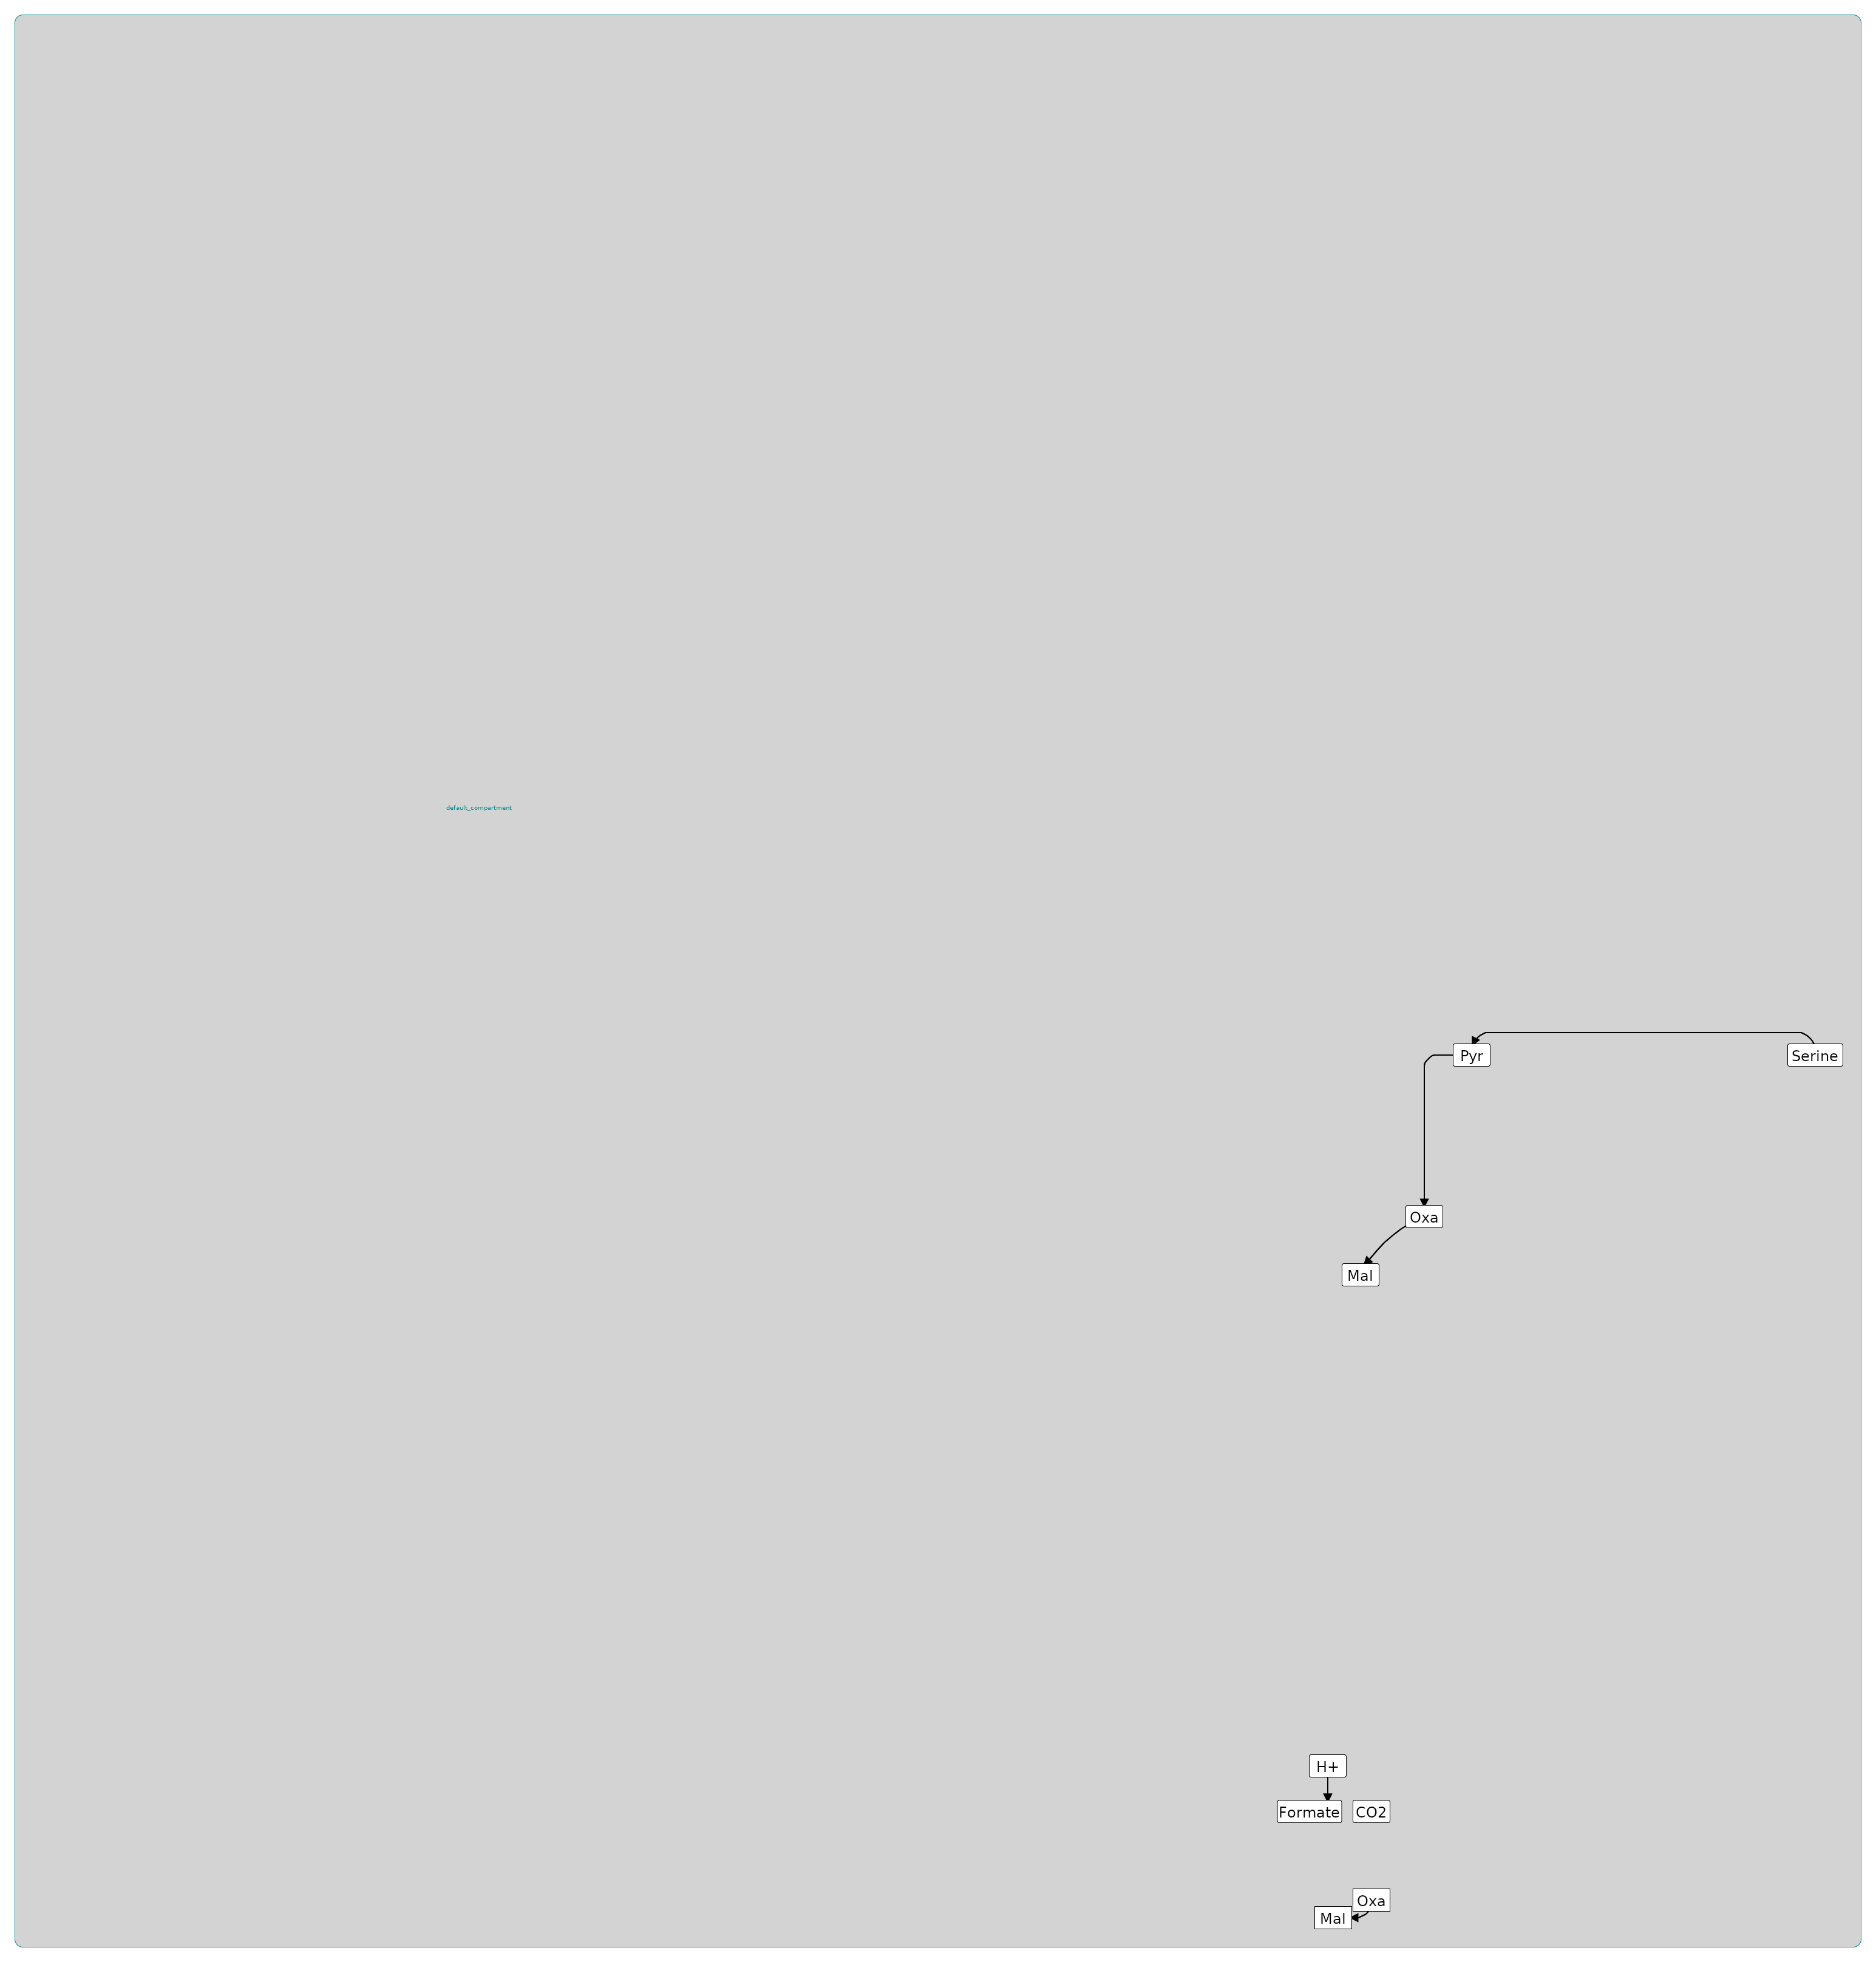

In [48]:
M0.draw()

In [49]:
# for comp in curveDict.keys():
#     spcname = comp.split('_')[0]
#     rxnlabel = comp.split('_')[2]
#     rxnindex = int(comp.split('_')[3])
#     entry = comp.split('_')[4]
#     parts = c.split('_')
#     id = '_'.join(parts[:2] + [parts[-1]])

#     refindex = M0.getSpeciesReferenceIndexAssociatedWithSpecies(spcname,rxnlabel)

#     i = entry_list.index(entry)
#     linecoords = coords_list[i]

#     current_index = 0

#     for j, coord in enumerate(linecoords[:-1]):
#         if current_index != 0:
#             M0.addSpeciesReferenceCubicBezierCurveSegment(rxnlabel, rxnindex, refindex)

#         M0.setSpeciesReferenceCurveSegmentStartPointX(rxnlabel, linecoords[j][0], rxnindex, refindex, current_index,)
#         M0.setSpeciesReferenceCurveSegmentStartPointY(rxnlabel, linecoords[j][1], rxnindex, refindex, current_index)
#         M0.setSpeciesReferenceCurveSegmentEndPointX(rxnlabel, linecoords[j+1][0], rxnindex, refindex, current_index)
#         M0.setSpeciesReferenceCurveSegmentEndPointY(rxnlabel, linecoords[j+1][1], rxnindex, refindex, current_index)

#         M0.setSpeciesReferenceCurveSegmentBasePoint1X(rxnlabel, linecoords[j][0], rxnindex, refindex, current_index)
#         M0.setSpeciesReferenceCurveSegmentBasePoint1Y(rxnlabel, linecoords[j][1], rxnindex, refindex, current_index)
#         M0.setSpeciesReferenceCurveSegmentBasePoint2X(rxnlabel, linecoords[j+1][0], rxnindex, refindex, current_index)
#         M0.setSpeciesReferenceCurveSegmentBasePoint2Y(rxnlabel, linecoords[j+1][1], rxnindex, refindex, current_index)

#         current_index = current_index + 1

In [50]:
# M0.draw()